In [ ]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

Pacman Dependancies

In [ ]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

# Imports and Helper functions


In [ ]:
import gym
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [ ]:
device = torch.device('CUDA' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Set the seed for env, pytorch and random module
seed = 27
env.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

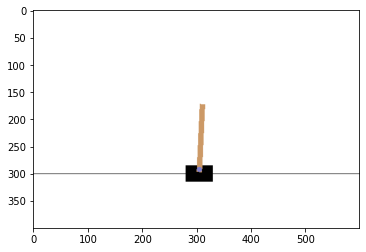

In [ ]:
env = gym.make('CartPole-v1')
env.reset()

prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

In [ ]:
state_space = env.observation_space.shape[0]
action_space = env.action_space.n

In [ ]:
def calculate_egreedy(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
                math.exp(-1. * steps_done / egreedy_decay)
    return epsilon

In [ ]:
# define hyperparameters
num_episode = 2000
gamma = 0.99
learning_rate = 0.01

egreedy = 0.9
egreedy_final = 0.1
egreedy_decay = 500

print_every = 10
egreedy_total = []

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self,):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(state_space, action_space)
    
    def forward(self, x):
        out = self.linear1(x)
        return out

In [ ]:
class QNet_Agent(object):
    def __init__(self):
        self.nn = NeuralNetwork().to(device)
        self.loss_func = nn.MSELoss()
        self.optimizer = optim.Adam(params = self.nn.parameters(), lr = learning_rate)

    def select_Action(self, state, epsilon):

        random_greedy = torch.rand(1)[0]

        if random_greedy > epsilon:
            with torch.no_grad():
                state = torch.Tensor(state).to(device)
                action_from_nn = self.nn(state)
                action = torch.max(action_from_nn, 0)[1]
                action = action.item()
        else:
            action = env.action_space.sample()

        return action

    def optimize(self, state, action, new_state, reward, done):
        
        state = torch.Tensor(state).to(device)
        new_state = torch.Tensor(new_state).to(device)
        reward = torch.Tensor([reward]).to(device)
        if done:
            target_value = reward
        else:
            new_state_values = self.nn(new_state).detach()
            max_new_state_values = torch.max(new_state_values) 
            target_value = reward + gamma * max_new_state_values

        predicted_value = self.nn(state)[action]

        loss = self.loss_func(predicted_value, target_value)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
 

In [ ]:
agent = QNet_Agent()

In [ ]:
steps_total = []
total_reward = []
frames_total = 0
score_to_solve = 195
solved_after = 0
solved = False
for i_episode in range(num_episode):
    state = env.reset()
    step = 0
    #for step in range(100):
    while True:
        step += 1
        frames_total += 1
        epsilon = calculate_egreedy(frames_total)
        action = agent.select_Action(state, epsilon)
        new_state, reward, done, info = env.step(action)

        agent.optimize(state, action, new_state, reward, done)

        state = new_state
        # screen = env.render(mode='rgb_array')
        # plt.imshow(screen)
        # ipythondisplay.clear_output(wait=True)
        # ipythondisplay.display(plt.gcf())
        if done:
            steps_total.append(step)
            mean_rewards_100 = sum(steps_total[-100:])/100
            
            if (mean_reward_100 > score_to_solve and solved == False):
                print("SOLVED! After %i episodes " % i_episode)
                solved_after = i_episode
                solved = True
            if mean_rewards_100 > score_to_solve and solved == False:
                print("\n*** Episode %i *** \
                      \nAv.reward: [last %i]: %.2f, [last 100]: %.2f, [all]: %.2f \
                      \nepsilon: %.2f, frames_total: %i" 
                  % 
                  ( i_episode,
                    report_interval,
                    sum(steps_total[-report_interval:])/report_interval,
                    mean_reward_100,
                    sum(steps_total)/len(steps_total),
                    epsilon,
                    frames_total
                          ) 
                  )
                  
                elapsed_time = time.time() - start_time
                print("Elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

            break

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



 *** Episode 0 ***                       
Average Reward: [last 10]: 2.60, [last 100]: 26.00,                        
epsilon: 0.86, frames_total: 26

 *** Episode 10 ***                       
Average Reward: [last 10]: 18.40, [last 100]: 19.09,                        
epsilon: 0.63, frames_total: 210

 *** Episode 20 ***                       
Average Reward: [last 10]: 17.00, [last 100]: 18.10,                        
epsilon: 0.47, frames_total: 380

 *** Episode 30 ***                       
Average Reward: [last 10]: 12.40, [last 100]: 16.26,                        
epsilon: 0.39, frames_total: 504

 *** Episode 40 ***                       
Average Reward: [last 10]: 11.30, [last 100]: 15.05,                        
epsilon: 0.33, frames_total: 617

 *** Episode 50 ***                       
Average Reward: [last 10]: 11.00, [last 100]: 14.25,                        
epsilon: 0.29, frames_total: 727

 *** Episode 60 ***                       
Average Reward: [last 10]: 10.80, [

In [ ]:
print("Average reward: %.2f" % (sum(steps_total)/num_episodes))
print("Average reward (last 100 episodes): %.2f" % (sum(steps_total[-100:])/100))
if solved:
    print("Solved after %i episodes" % solved_after)
plt.figure(figsize=(12,5))
plt.title("Rewards")
plt.bar(torch.arange(len(steps_total)), steps_total, alpha=0.6, color='green', width=5)
plt.show()

Average reward: 16.36
Average reward (last 100 episodes): 29.61


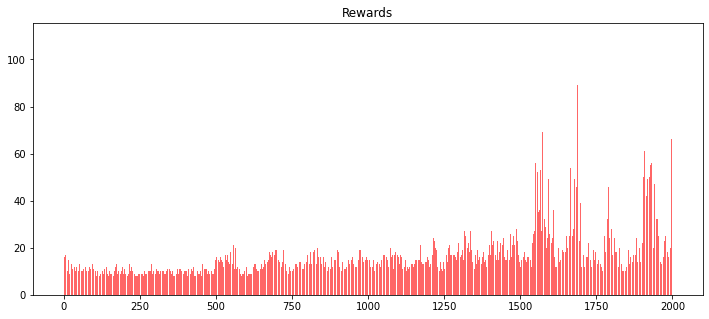

In [ ]:
# Plot graphs for rewards and steps
# plt.figure(figsize = (12, 5))
# plt.title('Rewards')
# plt.bar(torch.arange(len(total_reward)), total_reward, alpha = 0.6, color = 'green')
# plt.show()

plt.figure(figsize = (12, 5))
plt.title('Rewards')
plt.bar(torch.arange(len(steps_total)), steps_total, alpha = 0.6, color = 'red')
plt.show()

In [ ]:
env.close()